# General counting and plotting of filtered repeats of different unit lengths

### Loading required libraries and functions

In [1]:
import os
import sys

# ugly sys hack to allow parent dir imports
currentdir = os.path.abspath('')
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)

In [2]:
import argparse

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from python.scoring_filtering.tral_pvalues import load_repeatlists

### Declaring functions to load data, summarize and visualize

In [3]:
def get_repeat_counts(directory):
    unit_len_per_gene = {
            "gene": []
        }
    for i in range(1, 16):
        unit_len_per_gene[i] = []
        
    unit_num_per_len = {i: dict() for i in range(1, 16)}
    
    n_effective_min = 999
    n_effective_max = 0
    for file_name, repeat_list in load_repeatlists(directory):
        # get genomic region name, initialize new row in dictionary
        gen_region = file_name.replace(".pickle", "")        
        unit_len_per_gene['gene'].append(gen_region)
        for i in range(1, 16):
            unit_len_per_gene[i].append(0)

        # add counts for each unit length to dictionary
        for repeat in repeat_list.repeats:
            if repeat.l_effective > 15:
                continue
                
            n_eff = int(repeat.n_effective)
            if n_eff < n_effective_min:
                n_effective_min = n_eff
            if n_eff > n_effective_max:
                n_effective_max = n_eff
                
            try:
                unit_num_per_len[repeat.l_effective][n_eff] += 1
            except KeyError:
                unit_num_per_len[repeat.l_effective][n_eff] = 1
            
            unit_len_per_gene[repeat.l_effective][-1] += 1                

    unit_num_per_len_for_df = {i: list() for i in range(1, 16)}
    for i in range(1, n_effective_max + 1):
        for k in unit_num_per_len_for_df.keys():
            try:
                unit_num_per_len_for_df[k].append(unit_num_per_len[k][i])
            except KeyError:
                unit_num_per_len_for_df[k].append(0)

    unit_len_per_gene = pd.DataFrame(pd.DataFrame(unit_len_per_gene))

    unit_num_per_len = pd.DataFrame(pd.DataFrame(unit_num_per_len_for_df))
    unit_num_per_len["unit_count"] = np.arange(1, n_effective_max + 1)
    unit_num_per_len.set_index("unit_count", drop=True, inplace=True)
    
    return unit_len_per_gene, unit_num_per_len

In [4]:
def repeats_bar_plot(repeats_df):
    sums = repeats_df.drop(columns=['gene']).sum(axis = 0)
    total = sums.to_numpy().sum()
    ax = sums.plot.bar(grid=True)
    ax.text(0.9, 0.9, f'total={total}', ha="right", va="center", transform=ax.transAxes)

    plt.xlabel('Unit length')
    plt.ylabel('Counts')
    plt.grid(axis='x', alpha=0.5)

## Investigating test data
Test files are count data of 25 random genes. Both raw and filtered files are available.

### Raw test data 

In [39]:
test_data_raw = "/cfs/earth/scratch/verb/projects/CRC_STRs/results/test/repeats/selection/unscored"
raw_unit_len_per_gene, raw_unit_num_per_len = get_repeat_counts(test_data_raw)
# raw_unit_num_per_len.head()

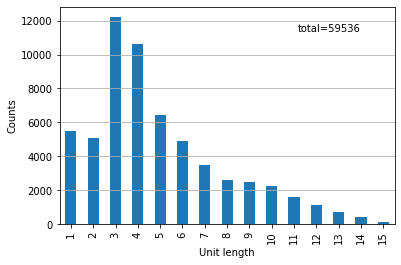

In [45]:
repeats_bar_plot(df_raw)

### Filtered test data 
Following filtering thresholds were applied: pvalue < 0.05, div >= 0.01. \
Scoring method: phylo_gap01

In [5]:
test_data_filt = "/cfs/earth/scratch/verb/projects/CRC_STRs/results/test/repeats/selection/filtered/phylo_gap01"
filt_unit_len_per_gene, filt_unit_num_per_len = get_repeat_counts(test_data_filt)

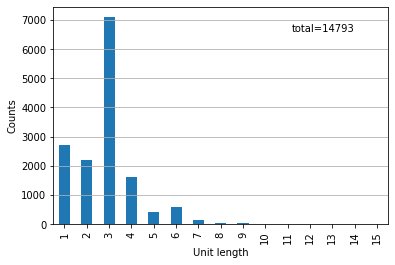

In [6]:
repeats_bar_plot(filt_unit_len_per_gene)

### Filtering + trimming gappy units
Below, 'trimming' approach is implemented:\
For rejected TRs, if there are trailing and/or leading gappy repeat units, these are trimmed and TRs are rescored (same scoring as above). If rejected repeat is accepted after trimming and rescoring, they are salvaged and not removed.

In [40]:
test_data_filt_trim = "/cfs/earth/scratch/verb/projects/CRC_STRs/results/test/repeats/selection/filtered/phylo_gap01_trim"
filt_trim_unit_len_per_gene, filt_trim_unit_num_per_len = get_repeat_counts(test_data_filt)
# filt_unit_num_per_len.head()

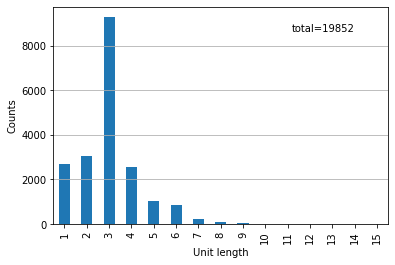

In [49]:
repeats_bar_plot(filt_trim_unit_len_per_gene)

## Investigating the full data set
All 19'814 genes from the GRCh38 human reference genome. For each gene, 5 KB of upstream sequence was included as promoter region.

In [5]:
full_data_filt = "/cfs/earth/scratch/verb/projects/CRC_STRs/results/repeats/filtered_p0.05_d0.01" # path to folder containing partitions
full_data_filt2 = "/cfs/earth/scratch/verb/projects/CRC_STRs/results/repeats/filtered_p0.05_d0.075"
full_data_refined = "/data/scratch/1193866/CRC_STRs/results/repeats/refined"
full_data_raw = "/cfs/earth/scratch/verb/projects/CRC_STRs/results/repeats/partitions"

### Count repeats in pickled RepeatList files
Only do this once and then write to a csv files for future use, as loading from RepeatLists takes a long time (~30 min for filtered, ~60 min for raw)

In [6]:
unit_len_df = pd.DataFrame()
unit_count_df = pd.DataFrame()
data_set = full_data_refined

for folder in os.listdir(data_set):
        if folder.startswith("part_"):
            folder = os.path.join(data_set, folder)
            if unit_len_df.empty:
                unit_len_df, unit_count_df = get_repeat_counts(folder)
                print(f"Finished loading folder {folder}")
            else:
                new_unit_len_df, new_unit_count_df = get_repeat_counts(folder)
                
                unit_len_df = unit_len_df.append(new_unit_len_df)
                unit_count_df = unit_count_df.add(new_unit_count_df, fill_value=0)
                print(f"Finished loading folder {folder}")
print(unit_len_df.shape)
print(unit_count_df.shape)

Finished loading folder /data/scratch/1193866/CRC_STRs/results/repeats/refined/part_5
Finished loading folder /data/scratch/1193866/CRC_STRs/results/repeats/refined/part_14
Finished loading folder /data/scratch/1193866/CRC_STRs/results/repeats/refined/part_8
Finished loading folder /data/scratch/1193866/CRC_STRs/results/repeats/refined/part_22
Finished loading folder /data/scratch/1193866/CRC_STRs/results/repeats/refined/part_21
Finished loading folder /data/scratch/1193866/CRC_STRs/results/repeats/refined/part_15
Finished loading folder /data/scratch/1193866/CRC_STRs/results/repeats/refined/part_17
Finished loading folder /data/scratch/1193866/CRC_STRs/results/repeats/refined/part_3
Finished loading folder /data/scratch/1193866/CRC_STRs/results/repeats/refined/part_1
Finished loading folder /data/scratch/1193866/CRC_STRs/results/repeats/refined/part_2
Finished loading folder /data/scratch/1193866/CRC_STRs/results/repeats/refined/part_12
Finished loading folder /data/scratch/1193866/CR

In [7]:
unit_len_df.to_csv("/cfs/earth/scratch/verb/projects/CRC_STRs/results/general/counts_per_unit_len_refined.csv", index=False)
unit_count_df.astype(int).to_csv("/cfs/earth/scratch/verb/projects/CRC_STRs/results/general/counts_per_repeat_number_refined.csv", index=True)

In [9]:
# If available, read data from .csv file
unit_len_counts_raw_df = pd.read_csv("/cfs/earth/scratch/verb/projects/CRC_STRs/results/general/counts_per_unit_len_raw.csv")
unit_number_counts_raw_df = pd.read_csv("/cfs/earth/scratch/verb/projects/CRC_STRs/results/general/counts_per_repeat_number_raw.csv")
unit_number_counts_raw_df.set_index("unit_count", inplace=True)

unit_len_counts_filt_df = pd.read_csv("/cfs/earth/scratch/verb/projects/CRC_STRs/results/general/counts_per_unit_len_p05_d01_trim.csv")
unit_number_counts_filt_df = pd.read_csv("/cfs/earth/scratch/verb/projects/CRC_STRs/results/general/counts_per_repeat_number_p05_d01_trim.csv")
unit_number_counts_filt_df.set_index("unit_count", inplace=True)

unit_len_counts_filt2_df = pd.read_csv("/cfs/earth/scratch/verb/projects/CRC_STRs/results/general/counts_per_unit_len_p0.05_d0.075_trim.csv")
unit_number_counts_filt2_df = pd.read_csv("/cfs/earth/scratch/verb/projects/CRC_STRs/results/general/counts_per_repeat_number_p0.05_d0.075_trim.csv")
unit_number_counts_filt2_df.set_index("unit_count", inplace=True)

unit_len_refined_df = pd.read_csv("/cfs/earth/scratch/verb/projects/CRC_STRs/results/general/counts_per_unit_len_refined.csv")
unit_number_refined_df = pd.read_csv("/cfs/earth/scratch/verb/projects/CRC_STRs/results/general/counts_per_repeat_number_refined.csv")
unit_number_refined_df.set_index("unit_count", inplace=True)

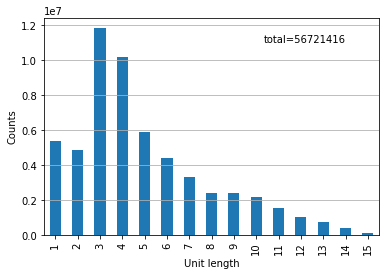

In [22]:
repeats_bar_plot(unit_len_counts_raw_df)

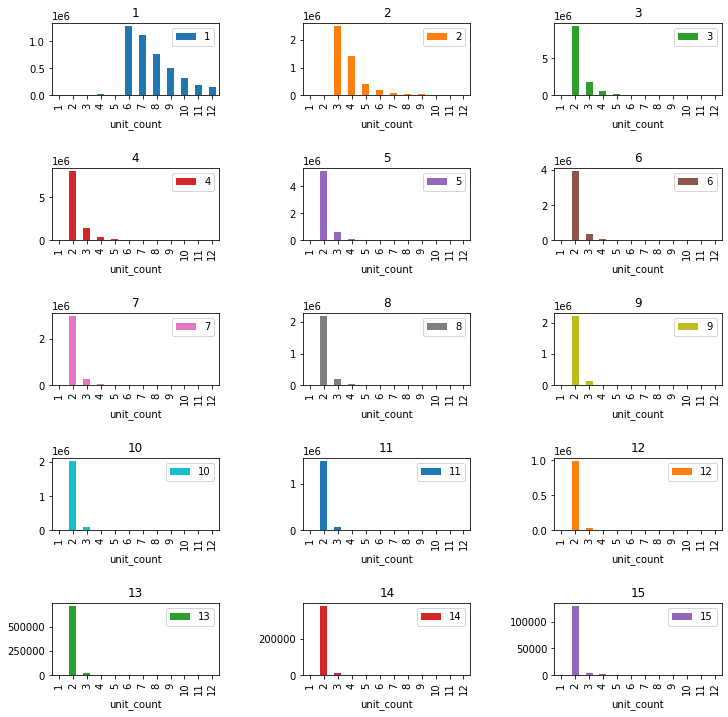

In [38]:
unit_number_counts_raw_df.head(12).plot.bar(subplots=True, layout=(5, 3), figsize=(12, 12), sharex=False, sharey=False)
plt.subplots_adjust(wspace=0.5, hspace=1)

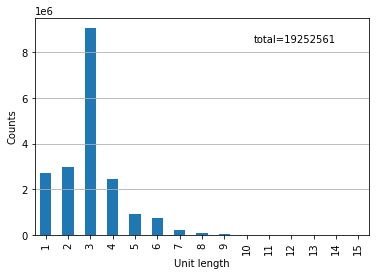

In [23]:
repeats_bar_plot(unit_len_counts_filt_df)

/cfs/earth/scratch/verb/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


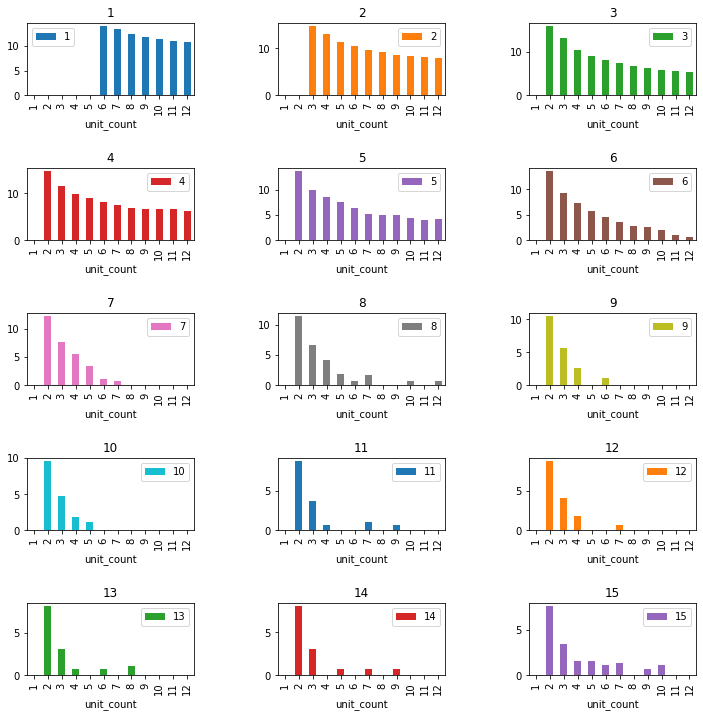

In [17]:
np.log(unit_number_counts_filt_df.head(12)).plot.bar(subplots=True, layout=(5, 3), figsize=(12, 12), sharex=False, sharey=False)
plt.subplots_adjust(wspace=0.5, hspace=1)

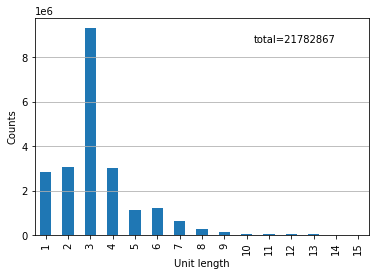

In [6]:
repeats_bar_plot(unit_len_counts_filt2_df)

/cfs/earth/scratch/verb/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


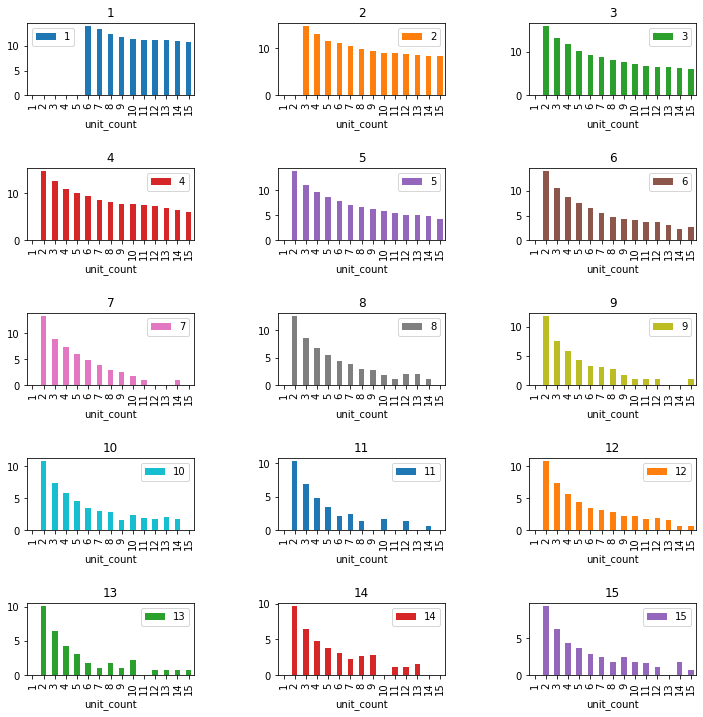

In [8]:
np.log(unit_number_counts_filt2_df.head(15)).plot.bar(subplots=True, layout=(5, 3), figsize=(12, 12), sharex=False, sharey=False)
plt.subplots_adjust(wspace=0.5, hspace=1)

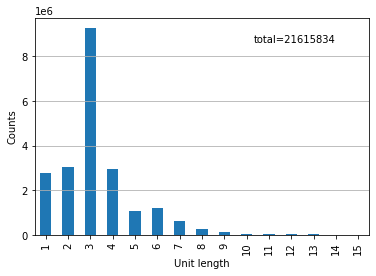

In [10]:
repeats_bar_plot(unit_len_refined_df)

/cfs/earth/scratch/verb/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


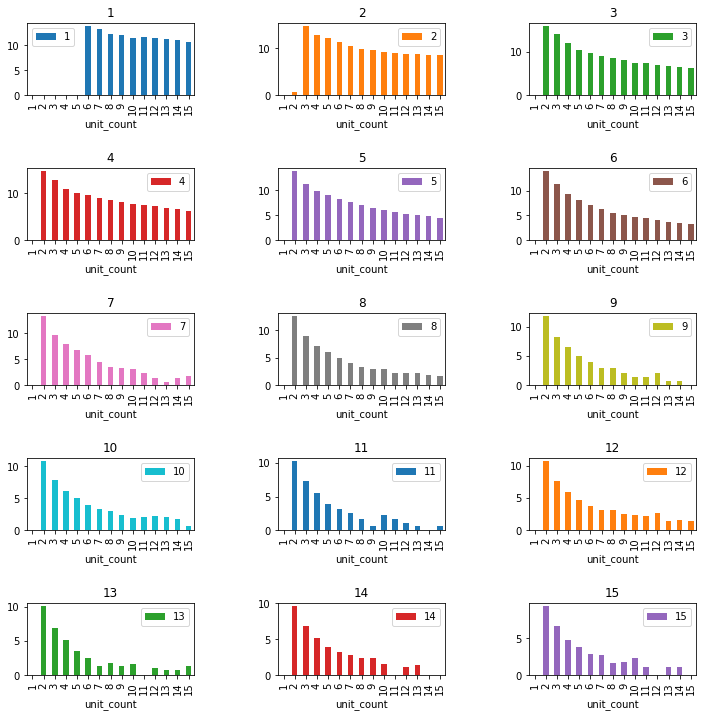

In [11]:
np.log(unit_number_refined_df.head(15)).plot.bar(subplots=True, layout=(5, 3), figsize=(12, 12), sharex=False, sharey=False)
plt.subplots_adjust(wspace=0.5, hspace=1)